<a href="https://colab.research.google.com/github/arminwitte/llsi/blob/estimate_initial_state/notebooks/example_diss_clone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/arminwitte/llsi.git

fatal: destination path 'llsi' already exists and is not an empty directory.


In [2]:
%cd llsi
!git checkout estimate_initial_state

/content/llsi
Already on 'estimate_initial_state'
Your branch is up to date with 'origin/estimate_initial_state'.


In [3]:
!pip install -e .

Obtaining file:///content/llsi
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for llsi (pyproject.toml) ... done
  Created wheel for llsi: filename=llsi-0.3.1-py3-none-any.whl size=3837 sha256=d36f5d4e597490d1ba752e6f0dfa715ddc3180334d83ba7def6575f485ba6998
  Stored in directory: /tmp/pip-ephem-wheel-cache-lvpos8gg/wheels/88/0f/fd/34bab3605c7fdd217dcb2659ba57605fe07bd49b0c70738c96
Successfully built llsi
  Attempting uninstall: llsi
    Found existing installation: llsi 0.3.1
    Uninstalling llsi-0.3.1:
      Successfully uninstalled llsi-0.3.1


In [4]:
#%cd ..

In [5]:
import numpy as np
import llsi
import matplotlib.pyplot as plt

In [6]:
d = np.load("data/heated_wire_data.npy")

In [7]:
t = d[:, 0]
Re = d[:, 1]
Nu = d[:, 2]

In [8]:
data = llsi.SysIdData(t=t, Re=Re, Nu=Nu)
data.equidistant(305002)
print(data.time().shape)
data.center()
data.downsample(18)
data.lowpass(1, 10)
data, test_set = data.split(0.8)
data.crop(start=1000)
data.center()
print(1 / data.Ts)

(305002,)
Splitting at 13556
239.9995820843808


M shape: (15, 1)
 0.0499612
 0.0499612
 0.0499612
 0.0499613
 0.0499612
 0.0499596
 0.0499598
 0.0499612
 0.0499612
 0.0499615
 0.0499612
 0.0499612
    218512
    218512
    218512
    218512
    218512
    218512
    218512
    218512
    218512
    218512
    218512
    218512
 0.0532261
 0.0532261
 0.0532261
  0.053226
 0.0532261
 0.0532263
   0.05323
 0.0532261
 0.0532261
 0.0532263
 0.0532261
 0.0532261
 0.0439899
 0.0439898
 0.0439899
 0.0439898
 0.0439899
 0.0439891
 0.0439908
 0.0439898
 0.0439899
 0.0439901
 0.0439899
 0.0439899
 0.0332118
 0.0332118
 0.0332118
 0.0332118
 0.0332118
 0.0332112
 0.0332126
 0.0332118
 0.0332118
  0.033212
 0.0332118
 0.0332118
 0.0269379
 0.0269379
 0.0269379
 0.0269378
 0.0269379
 0.0269371
 0.0269383
 0.0269379
 0.0269379
  0.026938
 0.0269379
 0.0269379
 0.0206983
 0.0206983
 0.0206983
 0.0206983
 0.0206983
 0.0206974
 0.0206982
 0.0206983
 0.0206983
 0.0206984
 0.0206983
 0.0206983
 0.0133749
 0.0133749
 0.0133749
 0.0133749
 0.0133749
 0.0

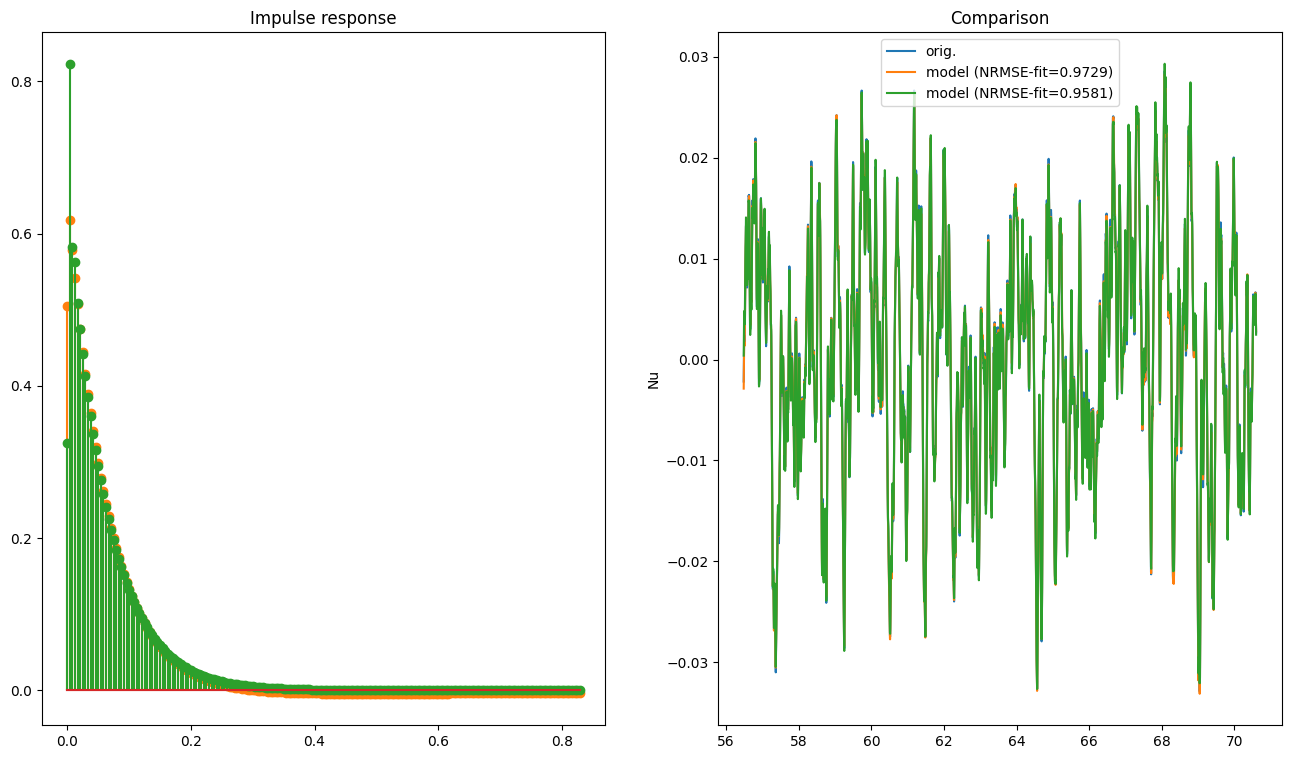

In [12]:
with llsi.Figure() as fig:
    mod1 = llsi.sysid(
        data, "Nu", "Re", (0, 100, 0), method="arx", settings={"lambda": 1e2}
    )
    mod1 = llsi.sysid(data, "Nu", "Re", 2, method="pem", settings={"init": "n4sid", "minimizer_kwargs":{"method":"BFGS"}})
    print("================")
    mod2 = llsi.sysid(
        data, "Nu", "Re", (3, 3, 0), method="pem", settings={"init": "arx", "minimizer_kwargs":{"method":"BFGS"}}
    )
    fig.plot([mod1, mod2], "impulse")
    fig.plot(
        {"mod": [mod1, mod2], "data": test_set, "y_name": "Nu", "u_name": "Re"},
        "compare",
    )

In [10]:
if False:
    import scipy

    t, y = scipy.signal.dimpulse(mod1.to_ss())

    fig, ax = plt.subplots()
    plt.plot(t, np.squeeze(y))
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    t, y = scipy.signal.impulse(mod1.to_ss(continuous=True))

    # fig, ax = plt.subplots()
    plt.plot(t[1:], np.squeeze(y)[1:])
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    t, y = scipy.signal.impulse(mod1.to_ss(continuous=True, method="euler"))

    # fig, ax = plt.subplots()
    plt.plot(t[1:], np.squeeze(y)[1:])
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    t, y = scipy.signal.dimpulse(mod1.to_tf())
    plt.plot(t[1:], np.squeeze(y)[1:])
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    t, y = scipy.signal.dimpulse(mod1.to_zpk())
    plt.plot(t[1:], np.squeeze(y)[1:])
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    plt.legend(["discrete", "cont", "euler", "tf", "zpk"])

[[0.50542661]
 [0.61768665]
 [0.57838833]
 [0.54156204]
 [0.50705241]]


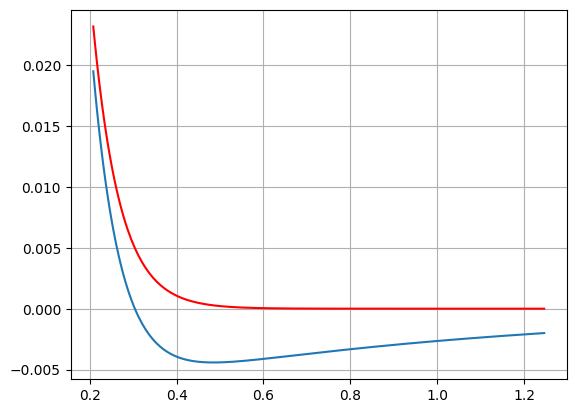

In [13]:
fig, ax = plt.subplots()
ti1, i1 = mod1.impulse_response(300)
ti2, i2 = mod2.impulse_response(300)
plt.plot(ti1[50:], i1[50:])
plt.plot(ti2[50:], i2[50:], "r")
plt.grid(True)

print(i1[:5])
# print(i2[:5])